将问题从求解“FY1 的飞行方向、飞行速度、烟幕干扰弹投放点、烟幕干扰弹起爆点”转换为求解“FY1 的飞行方向、飞行速度、无人机受领任务与投放烟幕干扰弹的时间间隔、烟幕干扰弹投放与起爆时间间隔”

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist as axisartist
from tqdm import tqdm
from numba import jit

In [17]:
fake_goal_coords = (0, 0, 0)  # 假目标坐标
real_goal_coords = (0, 200, 0)  # 真目标坐标
M1_coords = (20000, 0, 2000)  # 导弹 M1 坐标
M2_coords = (19000, 600, 2100)  # 导弹 M2 坐标
M3_coords = (18000, -600, 1900)  # 导弹 M3 坐标
FY1_coords = (17800, 0, 1800)  # 无人机 FY1 坐标
FY2_coords = (12000, 1400, 1400)  # 无人机 FY2 坐标
FY3_coords = (6000, -3000, 700)  # 无人机 FY3 坐标
FY4_coords = (11000, 2000, 1800)  # 无人机 FY4 坐标
FY5_coords = (13000, -2000, 1300)  # 无人机 FY5 坐标

In [18]:
FY1_theta = np.pi  # rad
FY1_v = 120  # m/s
M1_v = 300  # m/s
Cloud_v = 3  # m/s
Cloud_r = 10  # m
g = 9.8  # m/s^2

In [19]:
t_begin = 0
t_mission = t_begin + 1.5
t_explosion = t_mission + 3.6
t_expired = t_explosion + 20
t_end = np.sqrt(M1_coords[0]**2 + M1_coords[2]**2) / M1_v
print((t_begin, t_mission, t_explosion, t_expired, t_end), t_begin < t_mission < t_explosion < t_expired < t_end)

(0, 1.5, 5.1, 25.1, 66.99917080747261) True


问题1无需考虑 $y$ 轴，只考虑 $x$ 轴和 $z$ 轴。时间从警戒雷达发现来袭导弹时(同时无人机受领任务)起算，此外还有无人机投放烟幕干扰弹、烟幕干扰弹起爆(同时不一定为目标提供有效遮蔽)、烟幕干扰弹无法为目标提供有效遮蔽、导弹到达假目标一共5个时刻，分别定义为 $t_0, t_1, t_2, t_3, t_4$

**导弹坐标-时间函数**：

$$\begin{cases}
x_{\text{M}_1}(t) = x_{\text{M}_1,o} - v_{\text{M}_1} \frac{x_{\text{M}_1,o}}{\sqrt{x_{\text{M}_1,o}^2 + z_{\text{M}_1,o}^2}} t \\
y_{\text{M}_1}(t) = y_{\text{M}_1,o} = 0 \\
z_{\text{M}_1}(t) = z_{\text{M}_1,o} - v_{\text{M}_1} \frac{z_{\text{M}_1,o}}{\sqrt{x_{\text{M}_1,o}^2 + z_{\text{M}_1,o}^2}} t \\
\end{cases}$$

其中，$(x_{\text{M}_1,o}, y_{\text{M}_1,o}, z_{\text{M}_1,o})$ 为导弹初始坐标，$v_{\text{M}_1} = 300 \text{m/s}$ 为导弹速度，方向在 $xyz$ 坐标系为 $\overrightarrow{P_{\text{M}_1}P_{\text{G}_f}}$

**无人机坐标-时间函数**：

$$\begin{cases}
x_{\text{F}_1}(t) = x_{\text{F}_1,o} + v_{\text{F}_1} \cos \theta_{\text{F}_1} t \\
y_{\text{F}_1}(t) = y_{\text{F}_1,o} + v_{\text{F}_1} \sin \theta_{\text{F}_1} t \\
z_{\text{F}_1}(t) = z_{\text{F}_1,o} \\
\end{cases}, t \le t_1$$

其中，$(x_{\text{F}_1,o}, y_{\text{F}_1,o}, z_{\text{F}_1,o})$ 为无人机初始坐标，$\theta_{\text{F}_1}, v_{\text{F}_1}$ 为无人机飞行方向和速度

**烟幕干扰弹坐标-时间函数**：

$$\begin{cases}
x_{\text{B}}(t) = x_{\text{B},o} + v_{\text{F}_1} \cos \theta_{\text{F}_1} (t - t_1) \\
y_{\text{B}}(t) = y_{\text{B},o} + v_{\text{F}_1} \sin \theta_{\text{F}_1} (t - t_1) \\
z_{\text{B}}(t) = z_{\text{B},o} - \frac{1}{2} g (t - t_1)^2 \\
\end{cases}, t_1 < t \le t_2$$

其中，$(x_{\text{B},o}, y_{\text{B},o}, z_{\text{B},o})$ 为烟幕干扰弹初始坐标

**烟幕云团坐标-时间函数**：

$$\begin{cases}
x_{\text{C}}(t) = x_{\text{C},o} \\
y_{\text{C}}(t) = y_{\text{C},o} \\
z_{\text{C}}(t) = z_{\text{C},o} - v_{\text{C}} (t - t_2) \\
\end{cases}, t_2 < t \le t_3$$

其中，$(x_{\text{C},o}, y_{\text{C},o}, z_{\text{C},o})$ 为烟幕云团初始坐标，$v_{\text{C}} = 3 \text{m/s}$ 为烟幕云团下沉速度

目标函数：

$$\max_{\theta_{F_1}, v_{F_1}, t_m, t_e} \int_{t_{s_0}}^{t_{s_1}} \text{is\_shield}(t) dt \\
\text{s.t.} \begin{cases}
\text{is\_shield}(t) = \begin{cases} 1 & \text{if} ~|P_{M_1} P_C| < r_C \\ 0 &  \text{otherwise} \end{cases} \\
t_0 + t_m + t_e + 20 = t_1 + t_e + 20 = t_2 + 20 = t_3 < t_4 \\
\theta_{F_1} \in [0, 2 \pi) \\
v_{F_1} \in [70, 140] \\
t_m \in [0, 5] \\
t_e \in [0, 5] \\
\end{cases}$$

其中，$\text{is\_shield}(t)$ 表示在 $t$ 时刻导弹是否被烟幕云团遮蔽

In [20]:
@jit
def get_M1_coords(t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ''' 直线运动 '''
    x0, y0, z0 = M1_coords
    x = x0 - M1_v * x0 / np.sqrt(x0**2 + z0**2) * t
    y = np.full(t.shape, y0)
    z = z0 - M1_v * z0 / np.sqrt(x0**2 + z0**2) * t
    return (x, y, z)

@jit
def get_FY1_coords(t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ''' 直线运动 '''
    # mask = np.ones_like(t).astype(bool)
    mask = (t <= t_mission)
    mask = mask | np.roll(mask, 1)
    x0, y0, z0 = FY1_coords
    x = np.where(mask, x0 + FY1_v * np.cos(FY1_theta) * t, np.full(t.shape, np.nan))
    y = np.where(mask, y0 + FY1_v * np.sin(FY1_theta) * t, np.full(t.shape, np.nan))
    z = np.where(mask, np.full(t.shape, z0), np.full(t.shape, np.nan))
    return (x, y, z)

x_FY1_0, y_FY1_0, z_FY1_0 = FY1_coords
print('无人机初始坐标', (x_FY1_0, y_FY1_0, z_FY1_0))

xyz_FY1_1 = get_FY1_coords(np.array([t_mission]))
x_FY1_1, y_FY1_1, z_FY1_1 = tuple(zip(*xyz_FY1_1))[0]
print('无人机结束坐标', (x_FY1_1, y_FY1_1, z_FY1_1))

@jit
def get_Bomb_coords(t: np.ndarray):
    ''' 斜抛运动 '''
    mask = (t >= t_mission) & (t <= t_explosion)
    mask = mask | np.roll(mask, 1)
    t = t - t_mission
    x = np.where(mask, x_FY1_1 + FY1_v * np.cos(FY1_theta) * t, np.full(t.shape, np.nan))
    y = np.where(mask, y_FY1_1 + FY1_v * np.sin(FY1_theta) * t, np.full(t.shape, np.nan))
    z = np.where(mask, z_FY1_1 - 0.5 * g * t**2, np.full(t.shape, np.nan))
    return (x, y, z)

xyz_Bomb_0 = get_Bomb_coords(np.array([t_mission]))
x_Bomb_0, y_Bomb_0, z_Bomb_0 = tuple(zip(*xyz_Bomb_0))[0]
print('烟幕干扰弹初始坐标', (x_Bomb_0, y_Bomb_0, z_Bomb_0))

xyz_Bomb_1 = get_Bomb_coords(np.array([t_explosion]))
x_Bomb_1, y_Bomb_1, z_Bomb_1 = tuple(zip(*xyz_Bomb_1))[0]
print('烟幕干扰弹结束坐标', (x_Bomb_1, y_Bomb_1, z_Bomb_1))

@jit
def get_Cloud_coords(t):
    """ 直线运动 """
    mask = (t >= t_explosion) & (t <= t_expired)
    mask = mask | np.roll(mask, 1)
    t = t - t_explosion
    x = np.where(mask, x_Bomb_1, np.full(t.shape, np.nan))  # 没有水平速度
    y = np.where(mask, y_Bomb_1, np.full(t.shape, np.nan))  # 没有水平速度
    # x = np.where(mask, x_Bomb_1 + FY1_v * np.cos(FY2_theta) * t, np.full(t.shape, np.nan))  # 有水平速度
    # y = np.where(mask, y_Bomb_1 + FY1_v * np.sin(FY2_theta) * t, np.full(t.shape, np.nan))  # 有水平速度
    z = np.where(mask, z_Bomb_1 - Cloud_v * t, np.full(t.shape, np.nan))
    return (x, y, z)

xyz_Cloud_0 = get_Cloud_coords(np.array([t_explosion]))
x_Cloud_0, y_Cloud_0, z_Cloud_0 = tuple(zip(*xyz_Cloud_0))[0]
print('烟幕云团初始坐标', (x_Cloud_0, y_Cloud_0, z_Cloud_0))

xyz_Cloud_1 = get_Cloud_coords(np.array([t_expired]))
x_Cloud_1, y_Cloud_1, z_Cloud_1 = tuple(zip(*xyz_Cloud_1))[0]
print('烟幕云团结束坐标', (x_Cloud_1, y_Cloud_1, z_Cloud_1))

无人机初始坐标 (17800, 0, 1800)
无人机结束坐标 (17620.0, 2.2043642384652358e-14, 1800.0)
烟幕干扰弹初始坐标 (17620.0, 2.2043642384652358e-14, 1800.0)
烟幕干扰弹结束坐标 (17188.0, 7.494838410781801e-14, 1736.496)
烟幕云团初始坐标 (17188.0, 7.494838410781801e-14, 1736.496)
烟幕云团结束坐标 (17188.0, 7.494838410781801e-14, 1676.496)


In [ ]:
del FY1_theta, FY1_v 
del t_mission, t_explosion, t_expired
del x_FY1_1, y_FY1_1, z_FY1_1
del x_Bomb_1, y_Bomb_1, z_Bomb_1
del x_Cloud_1, y_Cloud_1, z_Cloud_1
del get_M1_coords, get_FY1_coords, get_Bomb_coords, get_Cloud_coords

In [ ]:
@jit
def get_M1_coords(t: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    ''' 直线运动 '''
    x0, y0, z0 = M1_coords
    x = x0 - M1_v * x0 / np.sqrt(x0**2 + z0**2) * t
    y = np.full(t.shape, y0)
    z = z0 - M1_v * z0 / np.sqrt(x0**2 + z0**2) * t
    return (x, y, z)
@jit
def get_FY1_coords(t: np.ndarray, t_mission, FY1_theta, FY1_v) -> tuple[np.ndarray, np.ndarray]:
    ''' 直线运动 '''
    # mask = np.ones_like(t).astype(bool)
    mask = (t <= t_mission)
    mask = mask | np.roll(mask, 1)
    x0, y0, z0 = FY1_coords
    x = np.where(mask, x0 + FY1_v * np.cos(FY1_theta) * t, np.full(t.shape, np.nan))
    y = np.where(mask, y0 + FY1_v * np.sin(FY1_theta) * t, np.full(t.shape, np.nan))
    z = np.where(mask, np.full(t.shape, z0), np.full(t.shape, np.nan))
    return (x, y, z)
@jit
def get_Bomb_coords(t: np.ndarray, t_mission, t_explosion, FY1_theta, FY1_v, x_FY1_1, y_FY1_1, z_FY1_1):
    ''' 斜抛运动 '''
    mask = (t >= t_mission) & (t <= t_explosion)
    mask = mask | np.roll(mask, 1)
    t = t - t_mission
    # x_FY1_1, y_FY1_1, z_FY1_1 = tuple(zip(*xyz_FY1_1))[0]
    x = np.where(mask, x_FY1_1 + FY1_v * np.cos(FY1_theta) * t, np.full(t.shape, np.nan))
    y = np.where(mask, y_FY1_1 + FY1_v * np.sin(FY1_theta) * t, np.full(t.shape, np.nan))
    z = np.where(mask, z_FY1_1 - 0.5 * g * t**2, np.full(t.shape, np.nan))
    return (x, y, z)
@jit
def get_Cloud_coords(t: np.ndarray, t_explosion, t_expired, x_Bomb_1, y_Bomb_1, z_Bomb_1):
    """ 直线运动 """
    mask = (t >= t_explosion) & (t <= t_expired)
    mask = mask | np.roll(mask, 1)
    t = t - t_explosion
    # x_Bomb_1, y_Bomb_1, z_Bomb_1 = tuple(zip(*xyz_Bomb_1))[0]
    x = np.where(mask, x_Bomb_1, np.full(t.shape, np.nan))  # 没有水平速度
    y = np.where(mask, y_Bomb_1, np.full(t.shape, np.nan))  # 没有水平速度
    # x = np.where(mask, x_Bomb_1 + FY1_v * np.cos(FY2_theta) * t, np.full(t.shape, np.nan))  # 有水平速度
    # y = np.where(mask, y_Bomb_1 + FY1_v * np.sin(FY2_theta) * t, np.full(t.shape, np.nan))  # 有水平速度
    z = np.where(mask, z_Bomb_1 - Cloud_v * t, np.full(t.shape, np.nan))
    return (x, y, z)

def obj(theta, v, t_m, t_e):
    global FY1_theta, FY1_v 
    global t_mission, t_explosion, t_expired
    global x_FY1_1, y_FY1_1, z_FY1_1
    global x_Bomb_1, y_Bomb_1, z_Bomb_1
    global x_Cloud_1, y_Cloud_1, z_Cloud_1
    FY1_theta = theta
    FY1_v = v
    t_mission = t_begin + t_m
    t_explosion = t_mission + t_e
    t_expired = t_explosion + 20

    xyz_FY1_1 = get_FY1_coords(
        np.array([t_mission]), t_mission, FY1_theta, FY1_v,
    )
    x_FY1_1, y_FY1_1, z_FY1_1 = tuple(zip(*xyz_FY1_1))[0]
    # print('无人机结束坐标', (x_FY1_1, y_FY1_1, z_FY1_1))
    xyz_Bomb_1 = get_Bomb_coords(
        np.array([t_explosion]), t_mission, t_explosion, FY1_theta, FY1_v, x_FY1_1, y_FY1_1, z_FY1_1,
    )
    x_Bomb_1, y_Bomb_1, z_Bomb_1 = tuple(zip(*xyz_Bomb_1))[0]
    # print('烟幕干扰弹结束坐标', (x_Bomb_1, y_Bomb_1, z_Bomb_1))
    xyz_Cloud_1 = get_Cloud_coords(
        np.array([t_expired]), t_explosion, t_expired, x_Bomb_1, y_Bomb_1, z_Bomb_1,
    )
    # x_Cloud_1, y_Cloud_1, z_Cloud_1 = tuple(zip(*xyz_Cloud_1))[0]
    # print('烟幕云团结束坐标', (x_Cloud_1, y_Cloud_1, z_Cloud_1))
    
    step=0.0001
    t_shield_begin = None
    t_shield_end = None
    t = np.arange(t_explosion, t_expired, step)
    xyz_c = get_Cloud_coords(t, t_explosion, t_expired, x_Bomb_1, y_Bomb_1, z_Bomb_1)
    xyz_m = get_M1_coords(t)
    xyz_c = np.array(xyz_c)
    xyz_m = np.array(xyz_m)
    is_shield = ((xyz_c - xyz_m) ** 2).sum(0) <= Cloud_r ** 2
    for _i, _t in zip(is_shield, t):
        if _i:
            t_shield_begin = _t if t_shield_begin is None else t_shield_begin
            t_shield_end = _t
    if t_shield_begin is None and t_shield_end is None:
        t_shield_duration = 0
    else:
        t_shield_duration = t_shield_end - t_shield_begin
    return - t_shield_duration

In [146]:
-obj(np.pi, 120, 1.5, 3.6)

0.05882999999777283

In [184]:
from sko.GA import GA
from sko.tool_kit import x2gray

size_pop = 100
x0 = np.array([np.pi, 120, 1.5, 3.6]).reshape(-1, 4)
ga = GA(
    func=obj,
    n_dim=4,
    size_pop=size_pop,
    max_iter=200,
    prob_mut=0.001,
    lb=[0, 70, 0, 0],
    ub=[2 * np.pi, 140, 5, 5],
    constraint_eq=tuple(),
    constraint_ueq=tuple(),
    precision=1e-07,
    early_stop=True,
)
ga.Chrom[0] = x2gray(x0, 4, ga.lb, ga.ub, ga.precision)
xbest, ybest = ga.run()
ybest *= -1
print(xbest, ybest)

[  3.1415927  120.           1.50000001   3.59999997] [0.05883]


In [191]:
from scipy.optimize import minimize

x0 = np.array([np.pi, 120, 1.5, 3.6])
bounds = [(0, 2*np.pi), (70, 140), (0, 5), (0, 5)]
res = minimize(
    fun=lambda x: obj(*x),
    x0=x0,
    method='SLSQP',  # SLSQP, COBYLA, trust-constr, L-BFGS-B
    bounds=bounds,
    constraints=[],
    options={'ftol': 1e-7, 'disp': True}
)
xbest, ybest = res.x, -res.fun
print(xbest, ybest)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.05882999999777283
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
最优 x: [  3.14159265 120.           1.5          3.6       ]
最优 f: 0.05882999999777283


In [242]:
xbest = (np.pi, 110, 1.5, 3.6)
ybest = -obj(*xbest)
ybest

0.06671999999747413

In [232]:
_num = 1000
x0 = np.array([np.pi, 120, 1.5, 3.6]).reshape(-1, 4).repeat(_num, axis=0)
x1 = x0.copy()
x1[:, 0] = np.linspace(0, 2*np.pi, _num)
y1 = np.array([-obj(*_) for _ in tqdm(x1)])
x2 = x0.copy()
x2[:, 1] = np.linspace(70, 140, _num)
y2 = np.array([-obj(*_) for _ in tqdm(x2)])
x3 = x0.copy()
x3[:, 2] = np.linspace(0, 5, _num)
y3 = np.array([-obj(*_) for _ in tqdm(x3)])
x4 = x0.copy()
x4[:, 3] = np.linspace(0, 5, _num)
y4 = np.array([-obj(*_) for _ in tqdm(x4)])

100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


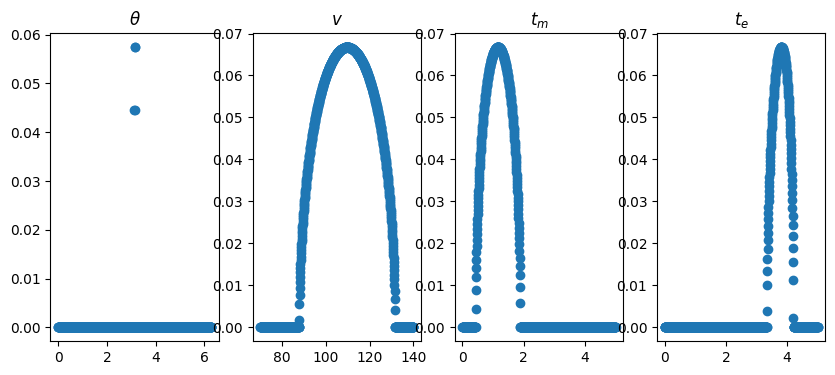

In [236]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 4, 1)
plt.plot(x1[:, 0], y1, 'o')
plt.title('$\\theta$')
plt.subplot(1, 4, 2)
plt.plot(x2[:, 1], y2, 'o')
plt.title('$v$')
plt.subplot(1, 4, 3)
plt.plot(x3[:, 2], y3, 'o')
plt.title('$t_m$')
plt.subplot(1, 4, 4)
plt.plot(x4[:, 3], y4, 'o')
plt.title('$t_e$')
plt.show()

In [241]:
y1.max(), y2.max(), y3.max(), y4.max()

(0.05740999999782659,
 0.06671999999747413,
 0.06671999999747413,
 0.06671999999747413)

猜测使得遮蔽时间最大的自变量不是一个数值而是一个范围，具体待验证

In [243]:
print(
    f'角度 {xbest[0] / np.pi * 180:.2f}°\n'
    f'速度 {xbest[1]:.2f} m/s\n'
    f'受领与投放时间间隔 {xbest[2]:.2f} s\n'
    f'投放与起爆时间间隔 {xbest[3]:.2f} s'
)

角度 180.00°
速度 110.00 m/s
受领与投放时间间隔 1.50 s
投放与起爆时间间隔 3.60 s


In [244]:
FY1_theta, FY1_v, t_m, t_e = xbest
t_mission = t_begin + t_m
t_explosion = t_mission + t_e
t_expired = t_explosion + 20
xyz_FY1_1 = get_FY1_coords(np.array([t_mission]), t_mission, FY1_theta, FY1_v)
x_FY1_1, y_FY1_1, z_FY1_1 = tuple(zip(*xyz_FY1_1))[0]
print('无人机结束坐标(烟幕干扰弹投放点)', (x_FY1_1, y_FY1_1, z_FY1_1))
xyz_Bomb_1 = get_Bomb_coords(np.array([t_explosion]), t_mission, t_explosion, FY1_theta, FY1_v, x_FY1_1, y_FY1_1, z_FY1_1)
x_Bomb_1, y_Bomb_1, z_Bomb_1 = tuple(zip(*xyz_Bomb_1))[0]
print('烟幕干扰弹结束坐标(烟幕干扰弹起爆点)', (x_Bomb_1, y_Bomb_1, z_Bomb_1))
xyz_Cloud_1 = get_Cloud_coords(np.array([t_expired]), t_explosion, t_expired, x_Bomb_1, y_Bomb_1, z_Bomb_1)
x_Cloud_1, y_Cloud_1, z_Cloud_1 = tuple(zip(*xyz_Cloud_1))[0]
print('烟幕云团结束坐标', (x_Cloud_1, y_Cloud_1, z_Cloud_1))

无人机结束坐标(烟幕干扰弹投放点) (17635.0, 2.0206672185931328e-14, 1800.0)
烟幕干扰弹结束坐标(烟幕干扰弹起爆点) (17239.0, 6.870268543216651e-14, 1736.496)
烟幕云团结束坐标 (17239.0, 6.870268543216651e-14, 1676.496)
